# Iris dataset - Regressão Logística - 3 classes

## Objetivos

Este notebook ilustra o problema de classificação.

O objetivo é classificar as amostras da Íris em 3 classes.
- o alvo é o índice da classe: 0, 1 ou 2
- função de perda é Entropia Cruzada
- rede é uma camada densa linear com duas entradas e três saídas (n. de classes)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmax_CrossEntropy_Otimizacao.png)

## Importação das bibliotecas

In [26]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display

## Dataset: Leitura, normalização e visualização dos dados

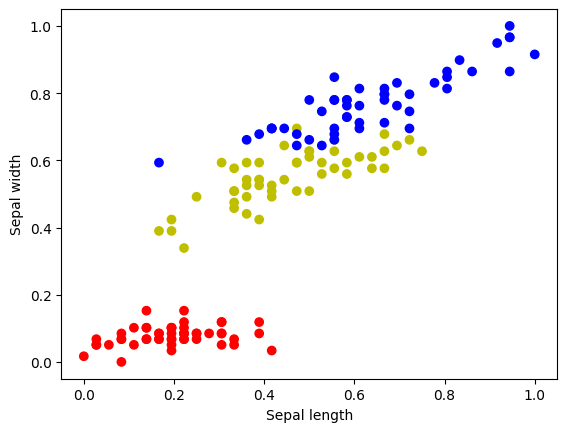

In [27]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [28]:
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

In [29]:
Y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLogisticaRede_2_3.png)

In [30]:
model = nn.Linear(2,3)  # 2 entradas e 3 saídas

In [31]:
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.0374, -0.5413],
                      [-0.4839,  0.5132],
                      [-0.3812,  0.1415]])),
             ('bias', tensor([-0.0194, -0.0210, -0.0331]))])

### Fazendo um predict

In [32]:
out = model(Variable(X_tensor[:4,:])) # 4 amostras
out

tensor([[-0.0644, -0.0938, -0.1083],
        [-0.0623, -0.0669, -0.0871],
        [-0.0511, -0.0487, -0.0683],
        [-0.0684, -0.0179, -0.0529]], grad_fn=<AddmmBackward0>)

In [33]:
oo = F.softmax(out,dim=1)
oo

tensor([[0.3415, 0.3316, 0.3269],
        [0.3366, 0.3351, 0.3284],
        [0.3350, 0.3358, 0.3293],
        [0.3260, 0.3429, 0.3311]], grad_fn=<SoftmaxBackward0>)

### Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/softmax.png)

In [34]:
F.softmax(out,dim=1)*100

tensor([[34.1516, 33.1629, 32.6855],
        [33.6591, 33.5055, 32.8354],
        [33.4979, 33.5769, 32.9252],
        [32.6012, 34.2900, 33.1088]], grad_fn=<MulBackward0>)

### Predição da classe

In [35]:
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred)
print(prob)

tensor([0, 0, 1, 1])
tensor([0.3415, 0.3366, 0.3358, 0.3429], grad_fn=<MaxBackward0>)


## Treinamento

### Classe para visualização dinâmica

In [36]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Softmax

In [37]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Final loss: 0.2063976675271988


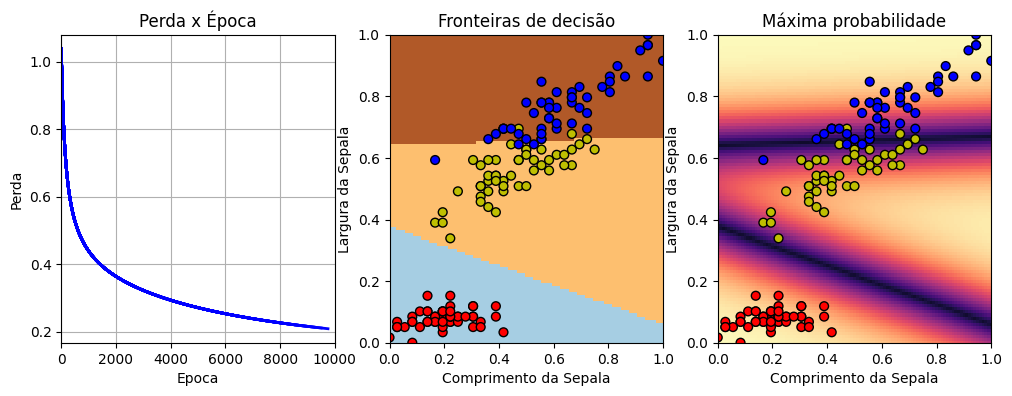

In [38]:
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

## Avaliação

### Parâmetros após treinamento

In [39]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ -3.1075, -14.7518],
                      [  1.3677,  -0.6116],
                      [  0.8372,  15.4767]])),
             ('bias', tensor([ 6.9493,  1.6249, -8.6477]))])

### Salvando os parâmetros treinados

In [40]:
os.makedirs('../models',exist_ok=True)
torch.save(model.state_dict(),'../models/RegrLog_Iris.pt')

In [41]:
! ls ../models/

RegrLog_Iris.pt


In [42]:
nn.init.constant(model.weight,0)
model.state_dict()

<ipython-input-42-0d5512203613>:1: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(model.weight,0)


OrderedDict([('weight',
              tensor([[0., 0.],
                      [0., 0.],
                      [0., 0.]])),
             ('bias', tensor([ 6.9493,  1.6249, -8.6477]))])

### Recuperando os pesos salvos

In [43]:
param_saved = torch.load('../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)
model.state_dict()

<ipython-input-43-079748b01dc8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  param_saved = torch.load('../models/RegrLog_Iris.pt')


OrderedDict([('weight',
              tensor([[ -3.1075, -14.7518],
                      [  1.3677,  -0.6116],
                      [  0.8372,  15.4767]])),
             ('bias', tensor([ 6.9493,  1.6249, -8.6477]))])

### Exatidão (acurácia) do classificador

Acurácia indica o número de acertos sobre o número total de amostras

In [44]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.96


### Matriz de confusão

In [45]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,3
2,0,3,47


## Atividades

### Perguntas:

1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado? **R -** Para resetar os pesos iniciais é necessário que instancie o modelo/redes neurais novamente

2. Experimente refazer o treinamento com diferentes valores de learning rate

Final loss: 0.1676296591758728


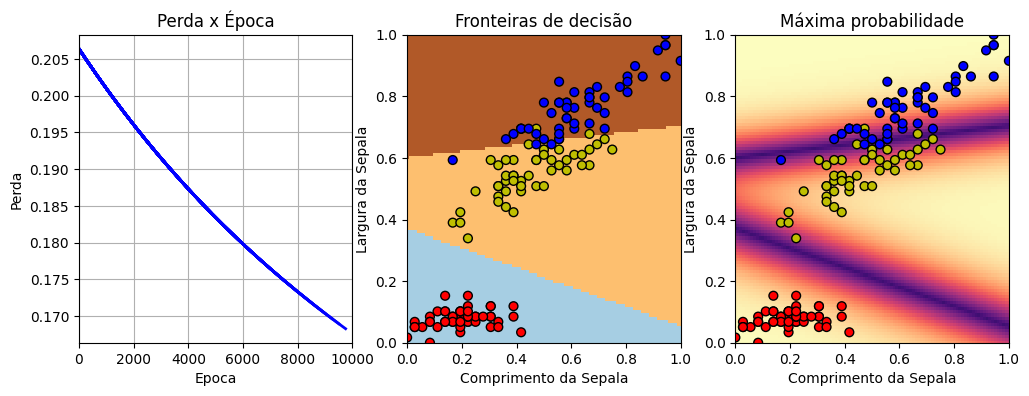

In [46]:
# Resolução do exercício 2

model2 = nn.Linear(2,3)  # 2 entradas e 3 saídas

out = model(Variable(X_tensor[:4,:])) # 4 amostras
oo = F.softmax(out,dim=1)
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)

lr = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

In [47]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.96


In [48]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,3
2,0,3,47


**Conclusão:** Depois de testar diferentes learning rates (.016, 0.17, 0.12, 0.11), sem nenhuma diferença no desempenho geral do modelo em relação ao learning rate anterior de 0.15. Eu modifiquei o learning rate para 0.1 e consegui uma ligeira melhora na matriz de confusão que passou de

|--|0 |1 | 2|
|--|--|--|--|
|0 |50|0 |0 |
|1 |0 |47| 3|
|2 | 0| 3|47|

para

|--|0 |1 | 2|
|--|--|--|--|
|0 |50|0 |0 |
|1 |0 |47| 2|
|2 | 0| 3|48|

### Exercícios:

1. Observando o gráfico de máxima probabilidade, responda:

    1. Qual é a amostra classificada corretamente, com alta probabilidade? **R - As áreas circulads em preto.**
    
    2. Qual é a amostra classificada erradamente, com alta probabilidade ou convicção? **R - Amostras circuladas em vermelho.**
    
    3. Qual é a amostra classificada corretamente, com baixa probabilidade? **R - As áreas circuladas em rosa.**

    4. Qual é a amostra classificada erradamente, com baixa probabilidade do modelo estar correto? **R - São as amostras circuladas em verde escuro.**
  [link da foto](https://github.com/tathi-martins/RNA-e-Deep-Learning---CESAR-School-2024.01/blob/main/Images/exercicio1_atividade_3_1.png). Ou visualize a foto mais abaixo.
    
2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias? **R - São três parâmetros iniciais, 2 pesos de X e um de viés. Mas se calcular o total da rede toda seria 9.**

3. Quantas entradas e quantas saídas esta rede possui? **R - Duas entradas e 3 saídas.**

4. Como se pode calcular a acurácia a partir da matriz de confusão? **Resposta abaixo**

5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
    - http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.max

**Resposta quesito 5:**
- Com um tensor como entrada `(torch.max(input))`: Retorna o maior valor no tensor.

- Com um tensor e dim especificado `(torch.max(input, dim))`: Retorna os valores máximos ao longo da dimensão e os índices correspondentes.

- Com dois tensores `(torch.max(input1, input2))`: Retorna um tensor com os maiores valores entre os tensores, comparados elemento a elemento.

Esses comportamentos tornam `torch.max´ muito flexível para diversos tipos de operações envolvendo máximos em tensores.

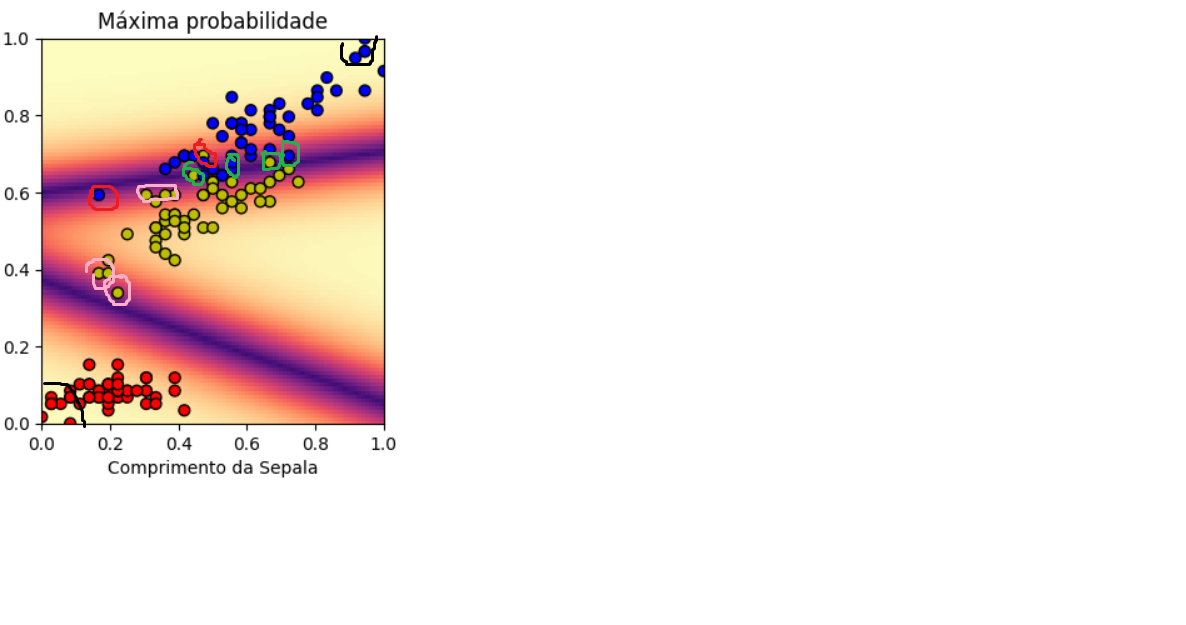

**Resolução da questão 4**

A fórmula seria a mesma só precisaríamos adaptar usando os dados da matriz de confusão.

Fórmula para a Acurácia:
Acurácia = Número de previsões corretas/Total de previsões

Para problemas multiclasse ou binário, a fórmula é:

Acurácia = ∑ valores diagonais/soma de todos os elementos da matriz

[TP FP]

[FN TN]

Ou seja, seria assim:

Acurácia = (TP+TN)/(TP+TN+FP+FN)

Para um problema multiclasses (n classes): A matriz de confusão é uma matriz *n×n*, onde cada elemento *Mij* representa a quantidade de amostras da classe *i* que foram classificadas como classe *j*.

Exemplos:

1. Problema binário:

- 1.1 Matriz de confusão:

[50 10]

[5 35]

TP = 50, TN = 35, FP = 10, FN = 5

Acurácia = (50 + 35) / (50 + 35 + 10 + 5) = 85/100 = 0.85 ou 85%

2. Problema multiclasses:
- 2.1 Matriz de confusão:

[30 5 2]

[6 25 3]

[4 7 35]

Soma dos valores na diagonal (previsões corretas):
30 + 25 + 35 = 90

Soma de todos os elementos:

30 + 5 + 2 + 6 + 25 + 3 + 4 + 7 + 35 = 117

Acurácia = 90/117 = 0.769 ou 76.9%

## Principais aprendizados